<a href="https://colab.research.google.com/github/wfwiggins/ICH-detection-demo/blob/main/ASNR_ICH_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Build an AI Model
## An example with Intracranial Hemorrhage Detection

Author: Walter F. Wiggins, MD, PhD

Email: walter.wiggins@duke.edu

Acknowledgements:
- 2019 Kaggle-RSNA Intracranial Hemorrhage Detection Challenge - original dataset
- Jeremy Howard (from fast.ai) - reduced size dataset amenable to this demonstration

## Environment Setup & Data Download

In [1]:
#@title Basic Setup
#@markdown - Install required Python libraries
#@markdown - Download files from demonstration GitHub repository

import warnings
warnings.filterwarnings("ignore")

import os, glob, re, random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.models import resnet18

from collections import defaultdict
from sklearn.metrics import accuracy_score

!pip install pydicom -q

import pydicom

matplotlib.rcParams['image.cmap'] = 'bone'


     |████████████████████████████████| 2.0 MB 10.0 MB/s 


In [4]:
#@title For the Live Demonstration Only!

#@markdown Run this cell to download and configure a token for the Kaggle *application programming interface (API)* from the GitHub repository for this session.
#@markdown This token will be expired after the live session. Follow the instructions in the next cell for future access.

%%bash

curl -o kaggle.json https://raw.githubusercontent.com/wfwiggins/ICH-detection-demo/main/assets/kaggle.json >/dev/null
if [ -e kaggle.json ]; then
    mkdir -p /root/.kaggle/
    mv kaggle.json /root/.kaggle/
    chmod 600 /root/.kaggle/kaggle.json 
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    69  100    69    0     0   3450      0 --:--:-- --:--:-- --:--:--  3631


In [6]:
#@title After the Initial Session...
#@markdown The token for the Kaggle API provided in the GitHub repository will be expired and deleted.
#@markdown To gain access to the data for future use, you will need to:
#@markdown 1. Create a Kaggle account at [kaggle.com](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F)
#@markdown 2. Join the [RSNA Intracranial Hemorrhage Detection Competition](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection) and accept the Competition Rules.
#@markdown 3. Go to your Kaggle account and "Create a New API Token".

#@markdown A file named `kaggle.json` will be downloaded to your computer. You will need to run this cell and upload it here before running the next cell.

from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
    _ = files.upload()

!if [ -e kaggle.json ]; then mkdir -p /root/.kaggle/; mv kaggle.json /root/.kaggle/; chmod 600 /root/.kaggle/kaggle.json; fi

In [ ]:
#@title Download the Annotation File from Kaggle
#@markdown The code in this cell will perform the following actions:
#@markdown - Authenticate the Kaggle API
#@markdown - Download and unzip the `stage_2_train.csv` (comma-separated values) file 
#@markdown
#@markdown This file contains the filenames for all of the images in the training dataset and their associated hemorrhage labels.

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

COMP_NAME = "rsna-intracranial-hemorrhage-detection"

train_meta_fp = f'{COMP_NAME}/stage_2_train.csv'
api.competition_download_file(COMP_NAME, train_meta_fp, "/content")

!unzip stage_2_train.csv.zip
!rm stage_2_train.csv.zip

100%|██████████| 16.2M/16.2M [00:00<00:00, 20.4MB/s]



Archive:  stage_2_train.csv.zip
  inflating: stage_2_train.csv       


# Exploring the Data

In [ ]:
#@title Load the Label File
#@markdown Here we load the label file `stage_2_train.csv` into a tabular data format called a `DataFrame`.
#@markdown - A random sample of the rows will be displayed below.
#@markdown - What do you notice about the IDs?

train_df = pd.read_csv('stage_2_train.csv')
train_df.sample(10)

,ID,Label
1259912,ID_850e8ad4d_intraventricular,0
403171,ID_e187b9b96_intraparenchymal,0
636802,ID_d86ae0c7d_subdural,0
4276772,ID_69187ab14_intraventricular,0
823622,ID_d67b516d0_intraventricular,0
4189380,ID_176c35595_epidural,0
1601800,ID_38046a5d5_subdural,1
1875732,ID_93b1fe477_epidural,0
4433642,ID_492fbc9e8_intraventricular,0
4447836,ID_720fec18f_epidural,0


In [ ]:
#@title Reformatting the Label File

#@markdown The labels above contain both the file ID of the individual image file and the subtype label, separated by a `_`.
#@markdown <br><br>We'll split the "ID" _string_ at the last occurrence of `_`, then reassign the resulting splits to different columns.

train_df[['ID', 'Subtype']] = train_df['ID'].str.rsplit(pat='_', n=1, expand=True)
print(train_df.shape)
train_df.head()

(4516842, 3)


,ID,Label,Subtype
0,ID_12cadc6af,0,epidural
1,ID_12cadc6af,0,intraparenchymal
2,ID_12cadc6af,0,intraventricular
3,ID_12cadc6af,0,subarachnoid
4,ID_12cadc6af,0,subdural


In [ ]:
#@title Cleaning up a Little More...

#@markdown Now we'll check for any errors in ID formatting, fix them (if any), and pivot the table such that there will only be one row for each unique ID.
#@markdown The hemorrhage subtype labels (including "any") will each have their own columns.

def fix_id(img_id):
    if not re.match(r'ID_[a-z0-9]+', img_id):
        sop = re.search(r'[a-z0-9]+', img_id)
        if sop:
            img_id_new = f'ID_{sop[0]}'
            return img_id_new
        else:
            print(img_id)
    return img_id

# test
assert(fix_id('ID_63eb1e259') == fix_id('ID63eb1e259'))
test = 'ID_dbdedfada'
assert(fix_id(test) == 'ID_dbdedfada')

# apply
train_df['ID'] = train_df['ID'].apply(fix_id)
train_new = train_df.pivot_table(index='ID', columns='Subtype').reset_index()
print(train_new.shape)
train_new.head()

(752803, 7)


ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000012eaf     0        0                0                0   
1        ID_000039fa0     0        0                0                0   
2        ID_00005679d     0        0                0                0   
3        ID_00008ce3c     0        0                0                0   
4        ID_0000950d7     0        0                0                0   

                               
Subtype subarachnoid subdural  
0                  0        0  
1                  0        0  
2                  0        0  
3                  0        0  
4                  0        0

Subtype
any                 107933
epidural              3145
intraparenchymal     36118
intraventricular     26205
subarachnoid         35675
subdural             47166
dtype: int64


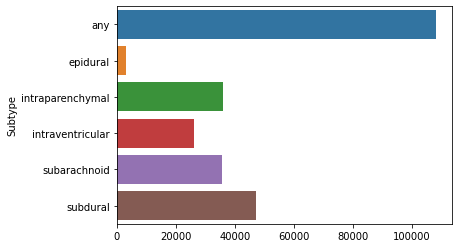

In [ ]:
#@title Exploring the Label Distribution

#@markdown Here, we sum over all rows to see how many of each label exist in our dataset.

#@markdown We see below that there is some degree of _class imbalance_ across the various hemorrhage subtypes.
#@markdown That is, there are far fewer cases with epidural hemorrhage than any of the other subtypes.

#@markdown > **Why this matters:**
#@markdown - If there is enough class imbalance, the model may _overfit_ to a class (or classes) with better representation in the training data.
#@markdown - We may employ different techniques in our model training to compensate for this imbalance.

subtype_ct = train_new['Label'].sum(axis=0)
print(subtype_ct)
sns.barplot(x=subtype_ct.values, y=subtype_ct.index);

Subtype
any                 100
epidural            100
intraparenchymal     22
intraventricular      8
subarachnoid         16
subdural             24
dtype: int64


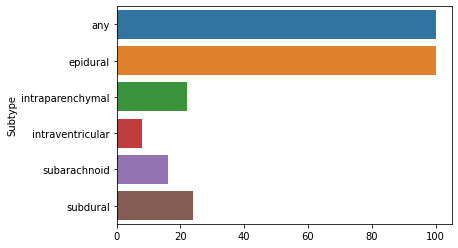

In [ ]:
#@title Examine a Subset of Images with Epidural Hemorrhage

#@markdown First, we filter on rows with `"epidural" == 1`, meaning that there is epidural hemorrhage on that image.
#@markdown Then, we sum across all rows again and display the results in tabular and graphical (i.e. bar plot or histogram) formats.

#@markdown Note that _all_ 100 images in this subset are positive for the "any" label, which makes sense, but is a nice "sanity check" that this label is accurate.
#@markdown If this were **not** the case, we would want to examine all images where the "epidural" label was marked positive but the "any" label was marked negative by the annotator(s).

filt = train_new["Label"]["epidural"] == 1
edh = train_new[filt].sample(100, random_state=42).reset_index(drop=True)
subtype_ct = edh['Label'].sum(axis=0)
print(subtype_ct)
sns.barplot(x=subtype_ct.values, y=subtype_ct.index);

In [ ]:
#@title Downloading an Example from the EDH Subset

def id_to_filepath(img_id):
    img_dir = f'{COMP_NAME}/stage_2_train'
    filepath = f'{img_dir}/{img_id}.dcm'
    return filepath

edh["filepath"] = edh["ID"].apply(id_to_filepath)

def download_file(fp):
    try:
        api.competition_download_file(COMP_NAME, fp, "/content")
    except:
        print(f'{fp} not found')

download_file(edh['filepath'].iloc[0])

100%|██████████| 513k/513k [00:00<00:00, 109MB/s]

In [ ]:
#@title Examine the DICOM Header (or Metadata)

#@markdown Enter the file name from the output of the cell above:
fp = "ID_e394200ce.dcm" #@param {"type": "string"}

ds = pydicom.dcmread(fp)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.189276234146955515960984605667132246459
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_e394200ce
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_630eb027'
(0020, 000d) Study Instance UID                  UI: ID_0ffdf20f08
(0020, 000e) Series Instance UID                 UI: ID_1d75e1fb4f
(0020, 0010) Study ID                            SH: ''
(0020, 00

# Examining the Pixels

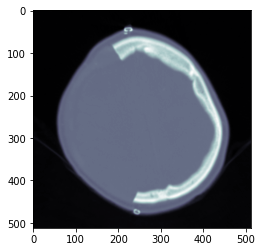

In [ ]:
#@title Extract the Pixel Data & Display an Image

px = ds.pixel_array
plt.imshow(px);

In [ ]:
#@title Rescaling the Pixels

#@markdown Note the "Rescale Intercept" and "Rescale Slope" tags in the DICOM metadata above. We need to utilize these to rescale the data to the expected Hounsfield unit scale.
#@markdown This will allow us to apply standard window widths and levels to the image.

print('Unscaled pixel value at (250, 250):', px[250, 250])
px_rescaled = (px * ds.RescaleSlope + ds.RescaleIntercept)
print('Rescaled:', px_rescaled[250, 250])

Unscaled pixel value at (250, 250): 1058
Rescaled: 34.0


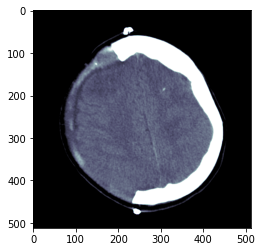

In [ ]:
#@title Viewing the Image in a Hemorrhage Window

#@markdown You may change the values below, then rerun the cell to view different windows.
window_width = 120 #@param {type: "integer"}
window_level = 40 #@param {type: "integer"}

def window_image(px, width=80, level=40):
    lower = level - width/2
    upper = level + width/2
    return np.clip(px, lower, upper)

px_windowed = window_image(px_rescaled, window_width, window_level)
plt.imshow(px_windowed);

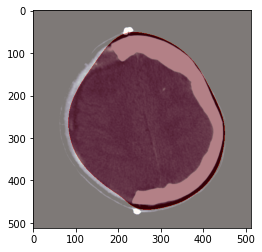

In [ ]:
#@title Creating a Mask to Crop the Image

#@markdown We have a lot of extra pixels in our initial image that aren't really contributing to our ability to make predictions about that image.
#@markdown For example, the air around the subject's head. The cradle or frame in which they are positioned.
#@markdown If we could crop some of that out, we'd be able to reduce the "noise" that our deep learning model will be subjected to.

#@markdown So in this cell, we normalize the pixels to a `[0, 1]` range, then blur the image and create a mask from the blurred image.
#@markdown This mask is then overlayed on the windowed image in a translucent red hue.

def normalize_px(px):
    return (px - px.min())/(px.max() - px.min())

def mask_from_blur(px, sigma_x=20, sigma_y=20, threshold=0.40, remove_max=True):
    normed = normalize_px(px)
    if remove_max: normed[normed == 1] = 0
    blurred = cv2.GaussianBlur(normed, (0,0), sigma_x, sigma_y)
    return blurred > threshold

mask = mask_from_blur(px_rescaled)
plt.imshow(px_windowed);
plt.imshow(mask, cmap=plt.cm.Reds, alpha=0.5);

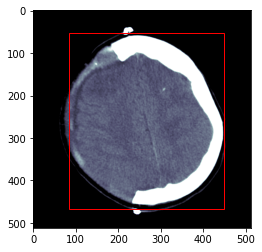

In [ ]:
#@title Turn the Mask into a Bounding Box

def bbox_from_mask(mask, padding=0):
    xs = mask.sum(axis=0).nonzero()
    x_min = max(xs[0].min() - padding, 0)
    x_max = min(xs[0].max() + padding, len(mask[0]))
    ys = mask.sum(axis=1).nonzero()
    y_min = max(ys[0].min() - padding, 0)
    y_max = min(ys[0].max() + padding, len(mask[1]))
    return (x_min, x_max), (y_min, y_max)

bb_x, bb_y = bbox_from_mask(mask)

bbox = Rectangle((bb_x[0], bb_y[0]), bb_x[1] - bb_x[0], bb_y[1] - bb_y[0], linewidth=1, edgecolor="r", fill=None)

_, ax = plt.subplots(1)
ax.imshow(px_windowed)
ax.add_patch(bbox)
plt.show();

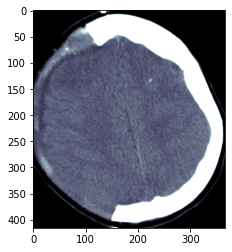

In [ ]:
#@title Crop the Image

cropped = px_windowed[bb_y[0]:bb_y[1], bb_x[0]:bb_x[1]]
plt.imshow(cropped);

# Working with a Reduced Dataset

In [ ]:
#@title Download a Reduced Dataset of JPEG Files

#@markdown The following dataset was created by Jeremy Howard, cofounder of Kaggle and founder of fast.ai.
#@markdown His intent was to provide folks with a reduced version of the RSNA Competition dataset to experiment with on the Kaggle platform.

#@markdown This dataset was created by using the techniques above to:
#@markdown 1. Take a representative sample of the original dataset.
#@markdown 2. Rescale the data to a reasonable window.
#@markdown 3. Resize the image files to a smaller, uniform size amenable to deep learning experiments.

!kaggle datasets download -d jhoward/rsna-hemorrhage-jpg
!unzip rsna-hemorrhage-jpg.zip > /dev/null
!rm rsna-hemorrhage-jpg.zip

100% 3.81G/3.82G [00:20<00:00, 187MB/s]
100% 3.82G/3.82G [00:20<00:00, 198MB/s]


In [ ]:
#@title How many files are in the dataset?

!ls train_jpg/train_jpg/ | wc -l

194082


In [ ]:
#@title Loading the Metadata File

#@markdown The `df_trn.fth` file includes a table of the image filenames and a subset of the data from the DICOM header, since JPEG files don't allow for the same structured metadata we get with DICOM.

path_meta = '/content/meta/meta/'
path_data = '/content/train_jpg/train_jpg/'

train_df = pd.read_feather(os.path.join(path_meta, 'df_trn.fth'))
train_df.head()

,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,...,WindowCenter,WindowCenter1,WindowWidth,WindowWidth1,fname,img_max,img_mean,img_min,img_pct_window,img_std
0,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,30.0,NaN,80.0,NaN,/home/jhoward/data/rsna/stage_1_train_images/I...,2787,35.112926,-2000,0.164139,1166.720843
1,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,36.0,36.0,80.0,80.0,/home/jhoward/data/rsna/stage_1_train_images/I...,2412,234.549896,0,0.076015,392.132243
2,16,16,512,15,1.0,0.0,0.0,0.0,1.000000,0.000000,...,35.0,NaN,135.0,NaN,/home/jhoward/data/rsna/stage_1_train_images/I...,2806,482.248981,0,0.241489,571.235614
3,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,30.0,NaN,80.0,NaN,/home/jhoward/data/rsna/stage_1_train_images/I...,2795,106.237759,-2000,0.242466,1253.462451
4,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,36.0,36.0,80.0,80.0,/home/jhoward/data/rsna/stage_1_train_images/I...,2491,536.799244,9,0.345436,568.654045


In [ ]:
#@title Reading in the Combined Metadata & Label Table

comb = pd.read_feather(os.path.join(path_meta, 'comb.fth'))
print(comb.columns)
comb.head()

Index(['BitsAllocated', 'BitsStored', 'Columns', 'HighBit',
       'ImageOrientationPatient', 'ImageOrientationPatient1',
       'ImageOrientationPatient2', 'ImageOrientationPatient3',
       'ImageOrientationPatient4', 'ImageOrientationPatient5',
       'ImagePositionPatient', 'ImagePositionPatient1',
       'ImagePositionPatient2', 'Modality', 'MultiImageOrientationPatient',
       'MultiImagePositionPatient', 'MultiPixelSpacing', 'MultiWindowCenter',
       'MultiWindowWidth', 'PatientID', 'PhotometricInterpretation',
       'PixelRepresentation', 'PixelSpacing', 'PixelSpacing1',
       'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPInstanceUID',
       'SamplesPerPixel', 'SeriesInstanceUID', 'StudyID', 'StudyInstanceUID',
       'WindowCenter', 'WindowCenter1', 'WindowWidth', 'WindowWidth1', 'fname',
       'img_max', 'img_mean', 'img_min', 'img_pct_window', 'img_std', 'any',
       'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural'],
      dtype

,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,...,img_mean,img_min,img_pct_window,img_std,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,35.112926,-2000,0.164139,1166.720843,0,0,0,0,0,0
1,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,234.549896,0,0.076015,392.132243,0,0,0,0,0,0
2,16,16,512,15,1.0,0.0,0.0,0.0,1.000000,0.000000,...,482.248981,0,0.241489,571.235614,1,0,1,1,0,0
3,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,106.237759,-2000,0.242466,1253.462451,1,0,1,0,0,0
4,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,536.799244,9,0.345436,568.654045,0,0,0,0,0,0


# Gathering the Data into Datasets

First, we'll gather the data into a special Pytorch _class_ called a `Dataset`. This will allow us to define custom functions for loading and preprocessing the data for input into the _deep neural network_ that we will train to predict whether hemorrhage is present in an image. A trained neural network will be referred to as a **model** as it represents one computational "model" of our dataset.

> Notes:
- We'll only focus on the "any" label in this demonstration, since we're not using enough data to reliably predict subtypes.
- The data will be split into _training_, _validation_, and _test_ datasets. We'll explain more about the differences between these datasets as we go.
- We'll examine the effect of class imbalance on our trained model's performance on a held-out test dataset.

In [ ]:
#@title Gather the Filenames from the Downloaded Dataset

#@markdown The number of files downloaded will be printed out below.
#@markdown This number should be `194082`.

fns = glob.glob(f'{path_data}/*')
print("Number of files:", len(fns))

Number of files: 194082


In [ ]:
#@title Defining the Custom Pytorch Dataset

#@markdown The code in this cell allows us create a Pytorch `Dataset` object that will perform preprocessing on the data to get it into the appropriate format for the model to process.
#@markdown It will also allow us to associate the source images from our reduced dataset with the appropriate labels for presentation to the model during training.

class HeadCTDataset(Dataset):
    def __init__(self, fns, df, transforms=None):
        self.fns = fns
        self.ids = [f.rsplit('/')[-1].split('.')[0] for f in fns]
        self.df = df
        self.tfms = transforms

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        id = self.ids[idx]
        fn = [f for f in self.fns if id in f][0]
        x = Image.open(fn)
        if self.tfms is not None:
            x = self.tfms(x)
        filt = self.df['fname'].str.contains(id)
        y = self.df[filt]['any'].values[0]
        return x, torch.tensor(y)


In [ ]:
#@title Defining our Model Architecture

#@markdown We will use a version of the ResNet-18 architecture, pretrained on ImageNet and modified to generate a binary prediciton (i.e. positive or negative for hemorrhage).

#@markdown > Notes:
#@markdown - ImageNet is a very large dataset of photographic images.
#@markdown - Models pretrained on ImageNet are commonly used in a process called _transfer learning_, whereby the model is further trained (or "fine-tuned") on a smaller dataset.
#@markdown - ResNet-18 is a much smaller architecture than is typically used for tasks of this type. "Deeper" architectures may provide more robust results for CT intracranial hemorrhage detection.

class Model(nn.Module):
    def __init__(self, arch=resnet18, num_classes=2):
        super().__init__()
        self.base = arch(pretrained=True)
        self.base.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        return self.base(x)

model = Model()

for param in model.parameters():
    param.requires_grad = False

for param in model.base.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#@title Experiment with Class Imbalance

#@markdown By default, this cell is set to balanced positive and negative classes.
#@markdown This means that there will be an equal number of positive and negative examples presented to the model during training.

#@markdown You may also experiment with the number of samples presented to the model in each round (or _epoch_) of training.

percent_positive = 0.5 #@param {type: "slider", min: 0.1, max: 0.9, step: 0.1}
n_samples = 100 #@param {type: "integer"}

tfms = Compose([
                Resize((256, 256)),
                ToTensor()
])

ds = HeadCTDataset(fns[:n_samples], comb, transforms=tfms)
n_dev = int(n_samples * 0.8)
n_train = int(n_dev * 0.75)
dev_ds, test_ds = random_split(ds, [n_dev, n_samples - n_dev])
train_ds, val_ds = random_split(dev_ds, [n_train, n_dev - n_train])

pct_neg = 1 - percent_positive
sampler = torch.utils.data.WeightedRandomSampler([pct_neg, percent_positive], n_samples)

train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

In [ ]:
#@title Running the Training Experiment

#@markdown Here, we define the _training and validation loops_, where we will iterate over the data in each split to train the model.

#@markdown In the training loop, we will update the _parameters_ (a.k.a. weights) of our model's final layer.
#@markdown This is referred to as _transfer learning_, as we are transferring the features learned from ImageNet to another task.

#@markdown For validation, the parameters are fixed, so the model does not learn _directly_ from the validation data.
#@markdown Still, we maintain a 3rd data split, the held-out test set for analyzing the model's final performance, as we can indirectly learn from the validation set as we update our hyperparameters to train a better model.

#@markdown Below, you may choose a number of _epochs_ or times we will repeat the training and validation processes.
#@markdown > _Hint:_ More epochs are not always better as a model can memorize the training data over time, resulting in worse performance on the validation and test sets.

n_epochs = 5 #@param {type: "integer"}

# Initialize loss and optimizer
model = model.cuda()
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(train_data, model, loss_func, optimizer):
    model.train()
    running_loss = 0.0
    steps = 0
    for imgs, targs in train_data:
        steps += 1
        imgs, targs = imgs.cuda(), targs.cuda()
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_func(outputs[:, 1], targs.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print("Avg training loss:", running_loss/steps, end='\r')
    return running_loss/steps

def validate(val_data, model, loss_func):
    model.eval()
    running_loss = 0.0
    steps = 0
    y_hats = []
    ys = []
    with torch.no_grad():
        for imgs, targs in val_data:
            steps += 1
            imgs, targs = imgs.cuda(), targs.cuda()
            preds = model(imgs)[:, 1]
            loss = loss_func(preds, targs.float())
            y_hats.extend(preds.tolist())
            ys.extend(targs.tolist())
            running_loss += loss.item()
            print("Avg validation loss:", running_loss/steps, end='\r')
    return running_loss/steps, y_hats, ys

best_metric = 0
best_epoch = 0
metrics = defaultdict(list)

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    print("-" * 8)
    metrics['Epoch'].append(epoch+1)
    # Training loop
    train_loss = train(train_dl, model, loss_func, optimizer)
    metrics['Training loss'].append(train_loss)
    print(f'Avg training loss: {train_loss:.4f}')
    # Validation loop
    val_loss, y_hats, ys = validate(val_dl, model, loss_func)
    metrics['Validation loss'].append(val_loss)
    print(f'Avg validation loss: {val_loss:.4f}')
    y_preds = [1 if y > 0.5 else 0 for y in y_hats]
    val_acc = accuracy_score(ys, y_preds)
    metrics['Validation accuracy'].append(val_acc)
    print(f'Validation accuracy: {val_acc:.2f}')
    if val_acc > best_metric:
        best_metric = val_acc
        best_epoch = epoch+1
        torch.save(model.state_dict(), 'best_model.pth')
    print("-" * 16)

print(f'Best accuracy {best_metric:.2f} achieved at Epoch {best_epoch}.')


Epoch 1/5
--------
Avg training loss: 0.4596
Avg validation loss: 1.0097
Validation accuracy: 0.4500
----------------
Epoch 2/5
--------
Avg training loss: 0.1078
Avg validation loss: 1.5652
Validation accuracy: 0.4500
----------------
Epoch 3/5
--------
Avg training loss: 0.0299
Avg validation loss: 2.1220
Validation accuracy: 0.4500
----------------
Epoch 4/5
--------
Avg training loss: 0.0122
Avg validation loss: 2.5814
Validation accuracy: 0.4500
----------------
Epoch 5/5
--------
Avg training loss: 0.0061
Avg validation loss: 2.9602
Validation accuracy: 0.4500
----------------
Best accuracy 0.4500 achieved at Epoch 1.


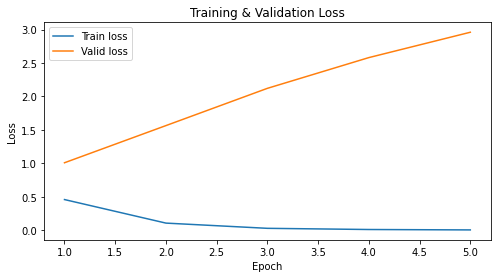

In [ ]:
#@title Examine the Training Curves

#@markdown The output above shows us how the training progressed over our pre-specified number of epochs.
#@markdown However, it can be helpful to visualize this by plotting the **training curves**, i.e. the training and validation losses over time.

#@markdown When the validation loss starts to go up, even as the training loss is decreasing, we say that a model is **overfitting**.

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title("Training & Validation Loss")
ax.plot(metrics['Epoch'], metrics['Training loss'], label="Train loss")
ax.plot(metrics['Epoch'], metrics['Validation loss'], label="Valid loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
fig.show();

In [ ]:
#@title Test the Model on the Held-out Test Set

#@markdown Finally, we want to take a look at the performance on the held-out test set.
#@markdown If there is a significant drop in accuracy on the test set, then we know our model has overfit to the training data and won't generalize well to new data.

#@markdown Adding more data and more heterogeneous data (from different populations and demographics) can help quite a bit in training a better model.
#@markdown Other things we can do to achieve better model performance include techniques such as data augmentation to **regularize** the model, i.e. keep it from overfitting.

model.load_state_dict(torch.load("best_model.pth"))
test_loss, y_hats, ys = validate(test_dl, model, loss_func)
print(f'Test loss: {test_loss:.4f}')
y_preds = [1 if y > 0.5 else 0 for y in y_hats]
test_acc = accuracy_score(ys, y_preds)
print(f'Test accuracy: {test_acc:.2f}')


Test loss: 1.0003
Test accuracy: 0.4000


In [ ]:
#@title
